In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm

class NewsStockCorrelation:
    """Robust news-stock correlation analysis with modern pandas datetime handling"""

    def __init__(self, news_data_path: str, stock_data_path: str):
        """Initialize with path validation"""
        self.news_data_path = self._validate_path(news_data_path, "News data")
        self.stock_data_path = self._validate_path(stock_data_path, "Stock data")
        self.news_df = None
        self.stock_df = None
        self.merged_df = None
        print(f"Initialized with:\n- News: {os.path.abspath(self.news_data_path)}\n- Stock: {os.path.abspath(self.stock_data_path)}")

    def _validate_path(self, path: str, name: str) -> str:
        """Validate file path exists and is readable"""
        if not os.path.exists(path):
            raise FileNotFoundError(f"{name} file not found at: {os.path.abspath(path)}")
        if not os.access(path, os.R_OK):
            raise PermissionError(f"Cannot read {name} file (check permissions)")
        return path

    def load_data(self) -> bool:
        """Load and validate data with modern datetime parsing"""
        try:
            # Load data as objects first to avoid deprecation warnings
            self.news_df = pd.read_csv(self.news_data_path, dtype={'date': 'object'})
            self.stock_df = pd.read_csv(self.stock_data_path, dtype={'Date': 'object'})

            # Convert to datetime with flexible parsing
            self.news_df['date'] = pd.to_datetime(
                self.news_df['date'],
                utc=True,
                format='mixed',
                dayfirst=False
            )
            self.stock_df['Date'] = pd.to_datetime(
                self.stock_df['Date'],
                utc=True,
                format='mixed',
                dayfirst=False
            )

            # Check for failed date parsing
            if self.news_df['date'].isnull().any():
                bad_dates = self.news_df[self.news_df['date'].isnull()]['date'].head().to_list()
                raise ValueError(f"Failed to parse news dates. Example bad formats: {bad_dates[:5]}")
            if self.stock_df['Date'].isnull().any():
                bad_dates = self.stock_df[self.stock_df['Date'].isnull()]['Date'].head().to_list()
                raise ValueError(f"Failed to parse stock dates. Example bad formats: {bad_dates[:5]}")

            # Rename columns consistently
            self.news_df = self.news_df.rename(columns={
                'date': 'Date',
                'stock': 'stock_symbol'
            })

            # Data quality checks
            self._validate_dataframes()
            
            # Process data
            self._process_dates()
            self._calculate_returns()
            
            print("\nData loaded successfully:")
            print(f"- News records: {len(self.news_df)}")
            print(f"- Stock records: {len(self.stock_df)}")
            print(f"- News date range: {self.news_df['Date'].min()} to {self.news_df['Date'].max()}")
            print(f"- Stock date range: {self.stock_df['Date'].min()} to {self.stock_df['Date'].max()}")
            
            return True
            
        except Exception as e:
            print(f"\nERROR in load_data(): {str(e)}", file=sys.stderr)
            return False

    def _validate_dataframes(self):
        """Validate required columns exist"""
        required_news_cols = ['Date', 'stock_symbol', 'headline']
        required_stock_cols = ['Date', 'stock_symbol', 'Adj Close']
        
        missing_news = [col for col in required_news_cols if col not in self.news_df.columns]
        missing_stock = [col for col in required_stock_cols if col not in self.stock_df.columns]
        
        if missing_news:
            raise ValueError(f"News data missing columns: {missing_news}")
        if missing_stock:
            raise ValueError(f"Stock data missing columns: {missing_stock}")

    def _process_dates(self):
        """Align dates between datasets with robust handling"""
        # Convert to timezone-naive dates
        self.news_df['Date'] = self.news_df['Date'].dt.tz_localize(None).dt.normalize()
        self.stock_df['Date'] = self.stock_df['Date'].dt.tz_localize(None).dt.normalize()
        
        # Find overlapping dates
        common_dates = set(self.news_df['Date']).intersection(set(self.stock_df['Date']))
        if not common_dates:
            news_dates = set(self.news_df['Date'])
            stock_dates = set(self.stock_df['Date'])
            unique_news = sorted(news_dates - stock_dates)[:5]
            unique_stock = sorted(stock_dates - news_dates)[:5]
            raise ValueError(
                f"No overlapping dates found.\n"
                f"Dates only in news: {unique_news}\n"
                f"Dates only in stock: {unique_stock}"
            )
            
        # Filter to overlapping dates
        self.news_df = self.news_df[self.news_df['Date'].isin(common_dates)]
        self.stock_df = self.stock_df[self.stock_df['Date'].isin(common_dates)]
        
        # Sort by date
        self.news_df = self.news_df.sort_values('Date')
        self.stock_df = self.stock_df.sort_values('Date')

    def _calculate_returns(self):
        """Calculate daily returns with validation"""
        if 'Adj Close' not in self.stock_df.columns:
            raise ValueError("'Adj Close' column missing in stock data")
            
        self.stock_df['daily_return'] = self.stock_df.groupby('stock_symbol')['Adj Close'].pct_change()
        
        # Check for invalid returns
        if self.stock_df['daily_return'].isna().all():
            raise ValueError("Could not calculate returns (check price data continuity)")

    def calculate_sentiment_scores(self) -> pd.DataFrame:
        """Calculate sentiment with progress feedback"""
        try:
            print("\nCalculating sentiment scores...")
            tqdm.pandas(desc="Processing headlines")
            self.news_df['sentiment_score'] = self.news_df['headline'].progress_apply(
                lambda x: TextBlob(str(x)).sentiment.polarity
            )
            
            # Aggregate by date and stock
            daily_sentiment = self.news_df.groupby(['Date', 'stock_symbol'])['sentiment_score'].agg(
                ['mean', 'count']
            ).reset_index()
            daily_sentiment.columns = ['Date', 'stock_symbol', 'avg_sentiment', 'article_count']
            
            print(f"Calculated sentiment for {len(daily_sentiment)} date/stock pairs")
            return daily_sentiment
            
        except Exception as e:
            print(f"\nERROR in calculate_sentiment_scores(): {str(e)}", file=sys.stderr)
            raise

    def analyze_correlations(self) -> dict:
        """Complete analysis pipeline with error handling"""
        try:
            if not self.load_data():
                return None
                
            sentiment = self.calculate_sentiment_scores()
            self.merged_df = pd.merge(
                self.news_df,
                self.stock_df,
                on=['Date', 'stock_symbol'],
                how='inner'
            )
            
            if self.merged_df.empty:
                raise ValueError("Merged DataFrame is empty - check stock symbols match between files")
            
            # Calculate correlations per stock
            correlations = {}
            for stock, group in self.merged_df.groupby('stock_symbol'):
                valid_data = group[['sentiment_score', 'daily_return']].dropna()
                if len(valid_data) >= 2:
                    corr, _ = pearsonr(valid_data['sentiment_score'], valid_data['daily_return'])
                    correlations[stock] = round(corr, 4)
                else:
                    correlations[stock] = None
                    print(f"Warning: Insufficient data for {stock} (only {len(valid_data)} valid pairs)")
            
            self.plot_results(correlations)
            return correlations
            
        except Exception as e:
            print(f"\nFATAL ERROR in analysis: {str(e)}", file=sys.stderr)
            return None

    def plot_results(self, correlations: dict):
        """Generate visualization output with updated Seaborn API usage"""
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Correlation coefficients - updated to use hue parameter
        plt.subplot(1, 2, 1)
        plot_data = pd.DataFrame({
            'Stock': list(correlations.keys()),
            'Correlation': list(correlations.values())
        })
        
        sns.barplot(
            data=plot_data,
            x='Stock',
            y='Correlation',
            hue='Stock',  # Assign hue to x variable
            palette='viridis',
            legend=False  # Disable legend since we're using x-axis labels
        )
        plt.title('Sentiment-Return Correlation by Stock')
        plt.xlabel('Stock Symbol')
        plt.ylabel('Pearson Correlation')
        plt.axhline(0, color='black', linestyle='--')
        
        # Plot 2: Scatter plot (unchanged as it doesn't produce the warning)
        plt.subplot(1, 2, 2)
        for stock in correlations:
            stock_data = self.merged_df[self.merged_df['stock_symbol'] == stock]
            sns.regplot(
                x='sentiment_score',
                y='daily_return',
                data=stock_data,
                label=stock,
                scatter_kws={'alpha': 0.6},
                ci=None
            )
        plt.title('Sentiment vs Daily Returns')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Daily Return')
        plt.legend()
        
        plt.tight_layout()
        plot_path = os.path.join(os.getcwd(), 'correlation_analysis.png')
        plt.savefig(plot_path)
        print(f"\nSaved visualization to '{plot_path}'")
        plt.show()

print("NewsStockCorrelation class successfully defined!")

NewsStockCorrelation class successfully defined!


Initialized with:
- News: C:\Users\tefer\Desktop\stock\news.csv
- Stock: C:\Users\tefer\Desktop\stock\stock.csv

Starting analysis...

Data loaded successfully:
- News records: 1848
- Stock records: 1059
- News date range: 2018-11-13 00:00:00 to 2020-06-10 00:00:00
- Stock date range: 2018-11-13 00:00:00 to 2020-06-10 00:00:00

Calculating sentiment scores...


Processing headlines: 100%|██████████████████████████████████████████████████████| 1848/1848 [00:01<00:00, 1636.60it/s]


Calculated sentiment for 441 date/stock pairs

Saved visualization to 'C:\Users\tefer\Desktop\stock\correlation_analysis.png'


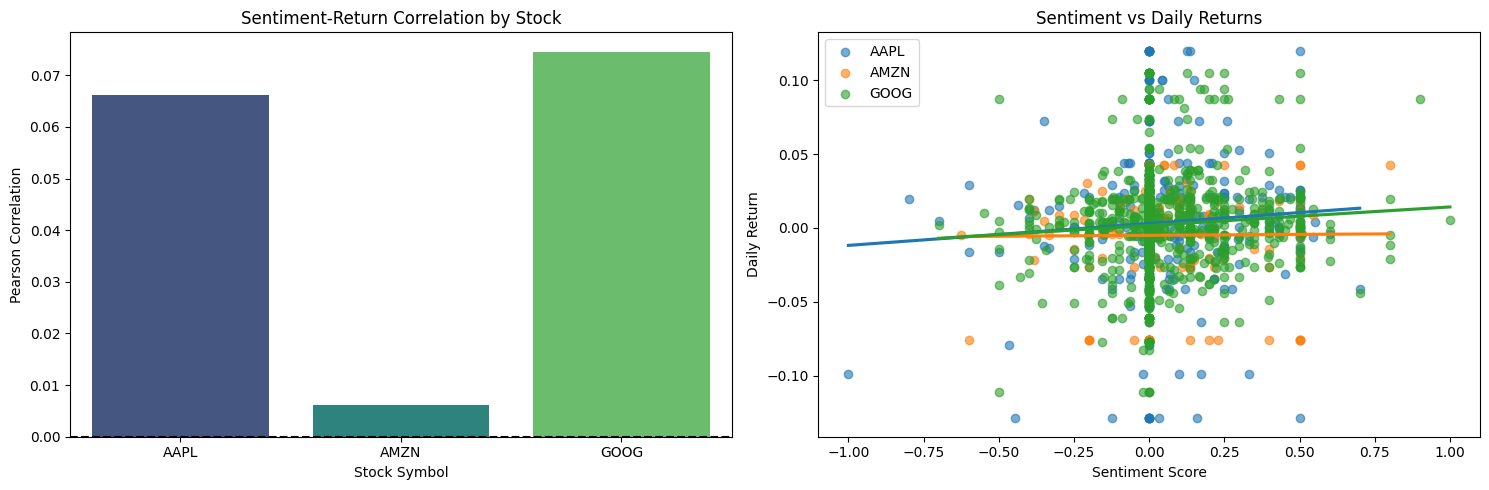


Final Results:
AAPL: 0.0662
AMZN: 0.0062
GOOG: 0.0746


In [3]:
# Cell 2: Execute the analysis
try:
    # Initialize with your file paths
    analyzer = NewsStockCorrelation(
        news_data_path='news.csv',  # Update with your actual path
        stock_data_path='stock.csv'  # Update with your actual path
    )
    
    print("\nStarting analysis...")
    results = analyzer.analyze_correlations()
    
    if results:
        print("\nFinal Results:")
        for stock, corr in results.items():
            print(f"{stock}: {corr if corr is not None else 'Insufficient data'}")
    else:
        print("\nAnalysis failed. Check error messages above.")
        
except Exception as e:
    print(f"\nCRITICAL ERROR: {str(e)}", file=sys.stderr)

In [ ]:
|